## Exploratory Data Analysis

In [40]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import colors

"""Change to the data folder"""
train_path = "./new_train/new_train"
val_path = './new_val_in/new_val_in'
# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate
#change plot settings so we can obtain higher resolution image for presentation
matplotlib.rcParams['savefig.dpi'] = 300

### Create a dataset class 

In [2]:
class ArgoverseDataset(Dataset):
    
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self): #len(val_dataset)
        return len(self.pkl_list)
    
    def __getitem__(self, idx): #val_dataset[0]
        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
        if self.transform:
            data = self.transform(data)
        return data

### Train/validation test dataset loading

In [3]:
train_dataset = ArgoverseDataset(data_path=train_path) 
val_dataset  = ArgoverseDataset(data_path=val_path) 

### EDA

In [4]:
len(train_dataset), len(val_dataset)

(205942, 3200)

GG, too many scenes, lets just take the first 5 scenens

In [5]:
df = []
for i, val in enumerate(train_dataset):
    df.append(val)
    if i >= 5:
        break
df = pd.DataFrame(df)

In [6]:
df_valid = []
for i, val in enumerate(val_dataset):
    df_valid.append(val)
    if i >= 5:
        break
df_valid = pd.DataFrame(df_valid)

In [7]:
df.columns

Index(['city', 'lane', 'lane_norm', 'scene_idx', 'agent_id', 'car_mask',
       'p_in', 'v_in', 'p_out', 'v_out', 'track_id'],
      dtype='object')

In [8]:
df['city']

0    PIT
1    MIA
2    PIT
3    MIA
4    MIA
5    MIA
Name: city, dtype: object

In [9]:
#pd.concat([pd.DataFrame(df['p_in'][0][0]).diff(), pd.DataFrame(df['p_out'][0][0]).diff()])

In [12]:
def shape_viz(x):
    try:
        return x.shape
    except:
        return 'scalar'
df.applymap(shape_viz)  
df.applymap(shape_viz)

,city,lane,lane_norm,scene_idx,agent_id,car_mask,p_in,v_in,p_out,v_out,track_id
0,scalar,"(72, 3)","(72, 3)",scalar,scalar,"(60, 1)","(60, 19, 2)","(60, 19, 2)","(60, 30, 2)","(60, 30, 2)","(60, 30, 1)"
1,scalar,"(261, 3)","(261, 3)",scalar,scalar,"(60, 1)","(60, 19, 2)","(60, 19, 2)","(60, 30, 2)","(60, 30, 2)","(60, 30, 1)"
2,scalar,"(288, 3)","(288, 3)",scalar,scalar,"(60, 1)","(60, 19, 2)","(60, 19, 2)","(60, 30, 2)","(60, 30, 2)","(60, 30, 1)"
3,scalar,"(378, 3)","(378, 3)",scalar,scalar,"(60, 1)","(60, 19, 2)","(60, 19, 2)","(60, 30, 2)","(60, 30, 2)","(60, 30, 1)"
4,scalar,"(306, 3)","(306, 3)",scalar,scalar,"(60, 1)","(60, 19, 2)","(60, 19, 2)","(60, 30, 2)","(60, 30, 2)","(60, 30, 1)"
5,scalar,"(585, 3)","(585, 3)",scalar,scalar,"(60, 1)","(60, 19, 2)","(60, 19, 2)","(60, 30, 2)","(60, 30, 2)","(60, 30, 1)"


In [13]:
df.head(2)

,city,lane,lane_norm,scene_idx,agent_id,car_mask,p_in,v_in,p_out,v_out,track_id
0,PIT,"[[3278.8716, 1968.7596, 0.0], [3282.6606, 1972...","[[3.7926118, 3.4899662, 0.0], [3.7891939, 3.49...",0,00000000-0000-0000-0000-000000000062,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0....","[[[3277.29638671875, 1947.6260986328125], [327...","[[[-0.0002748711849562824, -0.0002382324310019...","[[[3277.29638671875, 1947.625732421875], [3277...","[[[0.00022307495237328112, -0.0007175673381425...","[[[00000000-0000-0000-0000-000000000000], [000..."
1,MIA,"[[825.8388, 2049.997, 0.0], [825.92194, 2047.9...","[[0.08315584, -2.0102918, 0.0], [0.08315584, -...",1,00000000-0000-0000-0000-000000056485,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[[823.799560546875, 2068.298828125], [823.800...","[[[0.0008385988767258823, 0.14282366633415222]...","[[[823.811279296875, 2068.350341796875], [823....","[[[-0.011649041436612606, 0.41563326120376587]...","[[[00000000-0000-0000-0000-000000000000], [000..."


In [13]:
#df.car_mask[0] #first 6 is 1
#df.p_in[0][6]

In [14]:
#df.car_mask[0] #make sense as we have 60 vehicles
df.p_in[0][0][:4]

array([[3277.29638672, 1947.62609863],
       [3277.29614258, 1947.62597656],
       [3277.29614258, 1947.62585449],
       [3277.29614258, 1947.62597656]])

Data Cleaning steps we will do according to the data description: https://www.kaggle.com/c/cse151b-spring/discussion/233734

- lane and lane norm: For some reason, the z-coordinate is included, but is always 0, so you can ignore it and just look at the x,y.

- We do not need to predict v_in and v_out for the final project?

- If we used track id/agent id, we can just extract the last 8 char of the string

- 


Important: is there any way we can filter the car mask to only include presenting cars in each scene?

#### Qb.i what is the distribution of input positions for all agents (hint: use histogram)


In [14]:
input_distribution = []
iterator = tqdm(enumerate(train_dataset), total=int(len(train_dataset)))
for i, val in iterator:
    masked_p_in = val['p_in'][val['car_mask'].reshape(-1) == 1]
    masked_p_in = masked_p_in.reshape(masked_p_in.shape[0] * masked_p_in.shape[1], 2)
    for p in masked_p_in:
        input_distribution.append(p)

In [15]:
input_distribution = np.array(input_distribution)

In [16]:
input_distribution.shape

(34431249, 2)

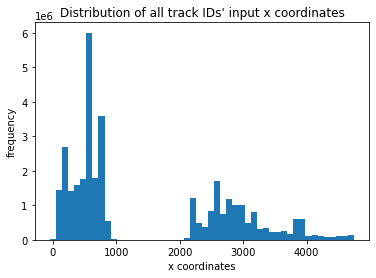

In [17]:
# x location
plt.hist(input_distribution[:, 0], bins=50)
plt.xlabel('x coordinates')
plt.ylabel('frequency')
plt.title('Distribution of all track IDs\' input x coordinates')
plt.show()

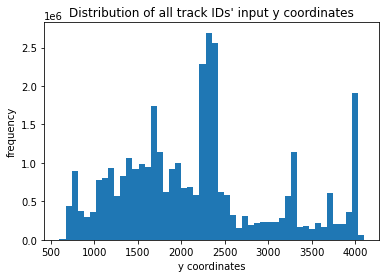

In [18]:
# y location
plt.hist(input_distribution[:, 1], bins=50)
plt.xlabel('y coordinates')
plt.ylabel('frequency')
plt.title('Distribution of all track IDs\' input y coordinates')
plt.show()

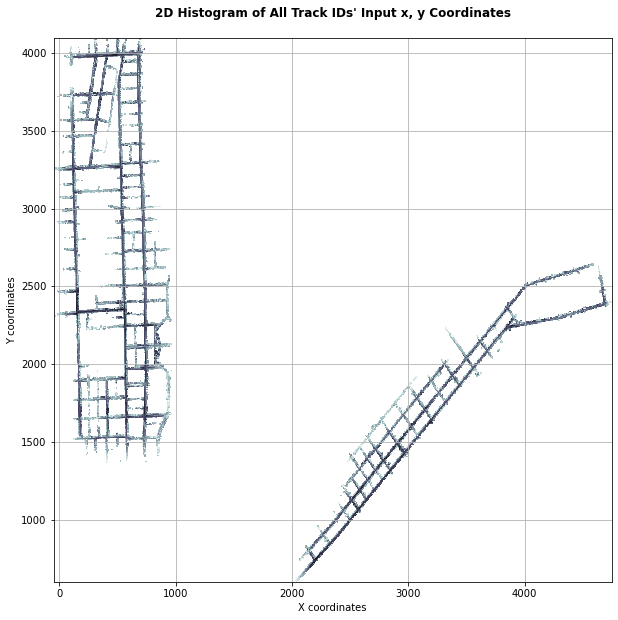

In [55]:
# x, y location
plt.figure(figsize=(10, 10))
plt.hist2d(input_distribution[:, 0], input_distribution[:, 1], 
           norm = colors.LogNorm(), 
           bins=1000, cmap = 'bone_r')
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')
plt.grid()
plt.title('2D Histogram of All Track IDs\' Input x, y Coordinates\n', fontweight ="bold")
plt.savefig("2d_hist_input_position.png")
plt.show()

In [50]:
output_distribution = []
iterator = tqdm(enumerate(train_dataset), total=int(len(train_dataset)))
for i, val in iterator:
    masked_p_out = val['p_out'][val['car_mask'].reshape(-1) == 1]
    masked_p_out = masked_p_out.reshape(masked_p_out.shape[0] * masked_p_out.shape[1], 2)
    for p in masked_p_out:
        output_distribution.append(p)
output_distribution = np.array(output_distribution)

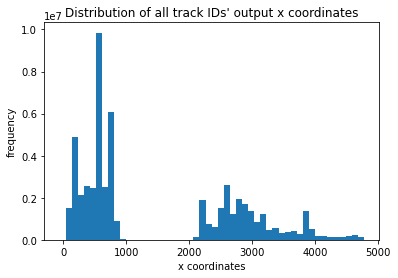

In [146]:
# x location
plt.hist(output_distribution[:, 0], bins=50)
plt.xlabel('x coordinates')
plt.ylabel('frequency')
plt.title('Distribution of all track IDs\' output x coordinates')
plt.show()

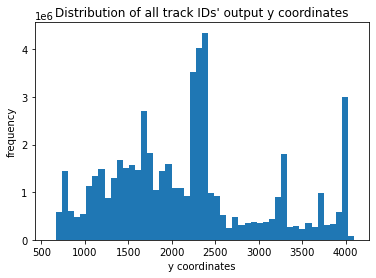

In [147]:
# y location
plt.hist(output_distribution[:, 1], bins=50)
plt.xlabel('y coordinates')
plt.ylabel('frequency')
plt.title('Distribution of all track IDs\' output y coordinates')
plt.show()

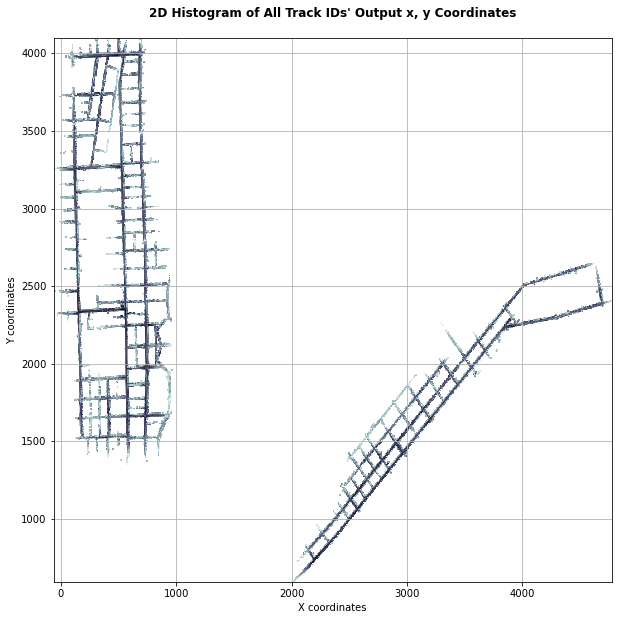

In [57]:
# x, y location
plt.figure(figsize=(10, 10))
plt.hist2d(output_distribution[:, 0], output_distribution[:, 1], 
           norm = colors.LogNorm(), 
           bins=1000, cmap = 'bone_r')
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')
plt.grid()
plt.title('2D Histogram of All Track IDs\' Output x, y Coordinates\n', fontweight ="bold")
plt.savefig("2d_hist_output_position.png")
plt.show()

# Velocity visualization

In [58]:
v_distribution = []
iterator = tqdm(enumerate(train_dataset), total=int(len(train_dataset)))
for i, val in iterator:
    masked_v = val['v_in'][val['car_mask'].reshape(-1) == 1]
    masked_v = masked_v.reshape(masked_v.shape[0] * masked_v.shape[1], 2)
    for p in masked_v:
        v_distribution.append(p)
v_distribution = np.array(v_distribution)

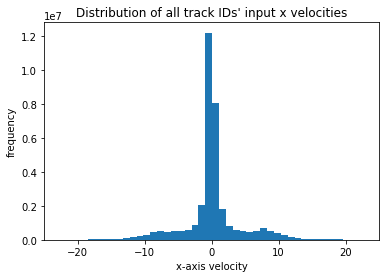

In [157]:
# x velocity
plt.hist(v_distribution[:, 0], bins=500)
plt.xlabel('x-axis velocity')
plt.ylabel('frequency')
plt.xlim(-25, 25)
plt.title('Distribution of all track IDs\' input x velocities')
plt.show()

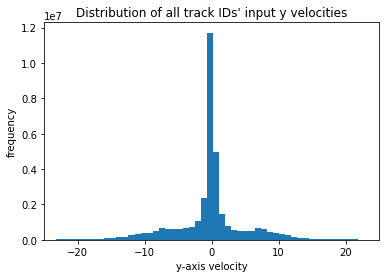

In [158]:
# y velocity
plt.hist(v_distribution[:, 1], bins=500)
plt.xlabel('y-axis velocity')
plt.ylabel('frequency')
plt.xlim(-25, 25)
plt.title('Distribution of all track IDs\' input y velocities')
plt.show()

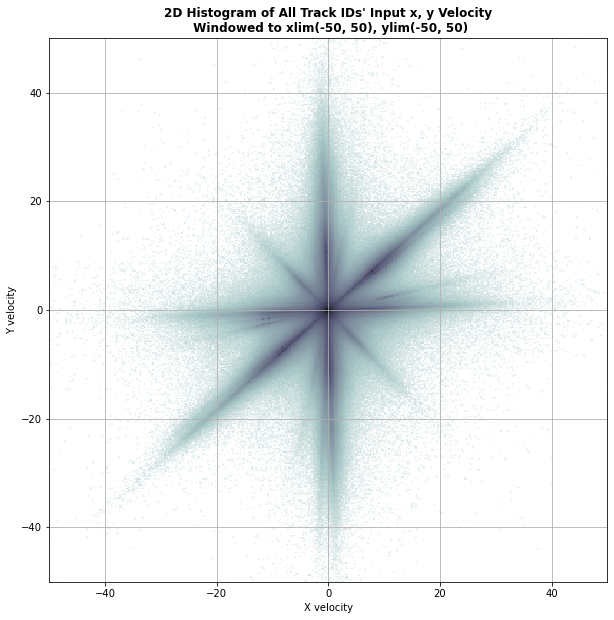

In [80]:
# x, y location
plt.figure(figsize=(10,10))
plt.hist2d(v_distribution[:, 0], v_distribution[:, 1], 
           norm = colors.LogNorm(), 
           bins=2000, cmap = 'bone_r')
plt.xlabel('X velocity')
plt.ylabel('Y velocity')
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.grid()
plt.title('2D Histogram of All Track IDs\' Input x, y Velocity\n Windowed to xlim(-50, 50), ylim(-50, 50)', fontweight ="bold")
plt.savefig("2d_hist_input_velocity.png")
plt.show()

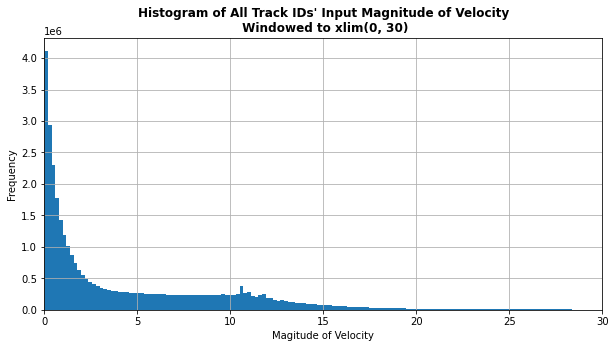

In [96]:
plt.figure(figsize=(10,5))
plt.hist((v_distribution[:, 0] ** 2 + v_distribution[:, 1] ** 2) ** 0.5, bins = 2000)
plt.xlim(0, 30)
plt.grid()
plt.xlabel('Magitude of Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of All Track IDs\' Input Magnitude of Velocity\n Windowed to xlim(0, 30)', fontweight ="bold")
plt.savefig("hist_input_velocity_mag_all_agent.png")
plt.show()

# Input velocity: Only target agent

In [85]:
vt_distribution = []
iterator = tqdm(enumerate(train_dataset), total=int(len(train_dataset)))
for i, val in iterator:
    masked_v = val['v_in'][val['agent_id'] == val['track_id'][:, 0, 0]]
    masked_v = masked_v.reshape(masked_v.shape[0] * masked_v.shape[1], 2)
    for p in masked_v:
        vt_distribution.append(p)
vt_distribution = np.array(vt_distribution)

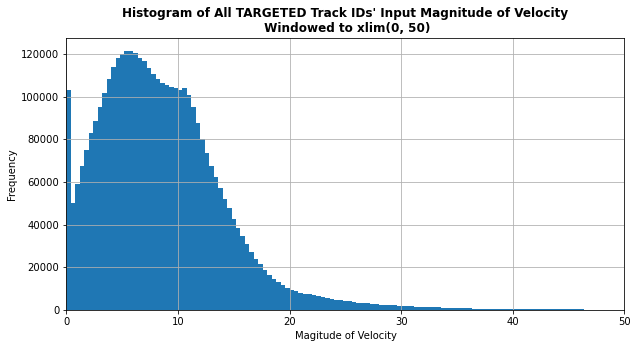

In [97]:
plt.figure(figsize=(10,5))
plt.hist((vt_distribution[:, 0] ** 2 + vt_distribution[:, 1] ** 2) ** 0.5, bins = 200)
plt.xlim(0, 50)
plt.grid()
plt.xlabel('Magitude of Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of All TARGETED Track IDs\' Input Magnitude of Velocity\n Windowed to xlim(0, 50)', fontweight ="bold")
plt.savefig("hist_input_velocity_mag_target.png")
plt.show()

# Output Velocity

In [98]:
vo_distribution = []
iterator = tqdm(enumerate(train_dataset), total=int(len(train_dataset)))
for i, val in iterator:
    masked_v = val['v_out'][val['car_mask'].reshape(-1) == 1]
    masked_v = masked_v.reshape(masked_v.shape[0] * masked_v.shape[1], 2)
    for p in masked_v:
        vo_distribution.append(p)
vo_distribution = np.array(vo_distribution)

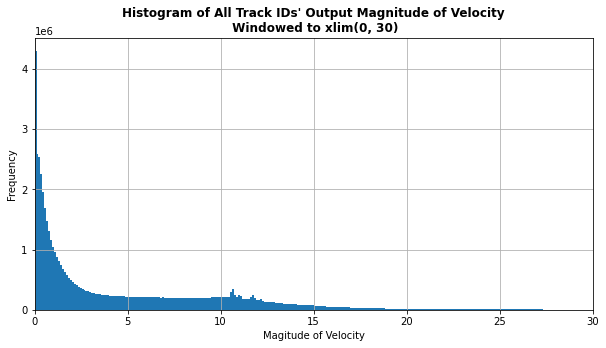

In [99]:
plt.figure(figsize=(10,5))
plt.hist((vo_distribution[:, 0] ** 2 + vo_distribution[:, 1] ** 2) ** 0.5, bins = 2000)
plt.xlim(0, 30)
plt.grid()
plt.xlabel('Magitude of Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of All Track IDs\' Output Magnitude of Velocity\n Windowed to xlim(0, 30)', fontweight ="bold")
plt.savefig("hist_output_velocity_mag_all_agent.png")
plt.show()

In [100]:
vot_distribution = []
iterator = tqdm(enumerate(train_dataset), total=int(len(train_dataset)))
for i, val in iterator:
    masked_v = val['v_in'][val['agent_id'] == val['track_id'][:, 0, 0]]
    masked_v = masked_v.reshape(masked_v.shape[0] * masked_v.shape[1], 2)
    for p in masked_v:
        vot_distribution.append(p)
vot_distribution = np.array(vot_distribution)

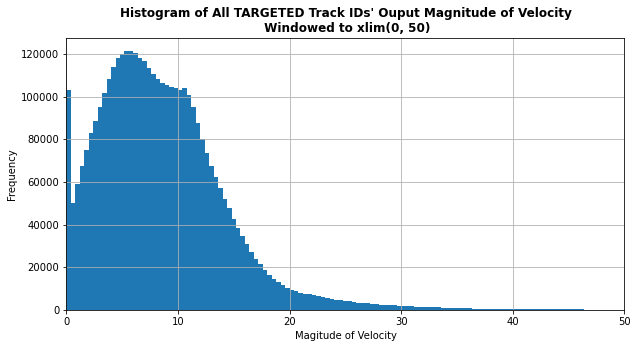

In [101]:
plt.figure(figsize=(10,5))
plt.hist((vot_distribution[:, 0] ** 2 + vot_distribution[:, 1] ** 2) ** 0.5, bins = 200)
plt.xlim(0, 50)
plt.grid()
plt.xlabel('Magitude of Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of All TARGETED Track IDs\' Ouput Magnitude of Velocity\n Windowed to xlim(0, 50)', fontweight ="bold")
plt.savefig("hist_output_velocity_mag_target.png")
plt.show()